In [9]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm


In [ ]:

def coletar_dados_yfinance(ticker: str, data_inicio: str, data_fim: str):
    """
    Coleta dados de mercado (pre√ßos hist√≥ricos) via yfinance.
    
    :para ticker: C√≥digo do ativo (ex.: 'PETR4.SA' para B3)
    :para data_inicio: Data inicial no formato 'YYYY-MM-DD'
    :para data_fim: Data final no formato 'YYYY-MM-DD'
    :return: DataFrame com dados de pre√ßos (ou vazio em caso de erro).
    """
    try:
        # yfinance aceita strings no formato 'YYYY-MM-DD' para start/end
        df = yf.download(ticker, start=data_inicio, end=data_fim)
        if df.empty:
            raise ValueError(f"N√£o foram obtidos dados para o ticker {ticker}")
        return df
    except Exception as e:
        print(f"Erro ao coletar dados para o ticker {ticker}: {e}")
        return pd.DataFrame()

def main():
    
    data_inicio = "2010-01-01"
    data_fim    = "2024-12-31"
    
    ticker = [
        "EGIE3.SA"
    ]
    
    # Entrada opcional do usu√°rio (tickers adicionais)
    tickers_input = input(
        "Digite os tickers adicionais separados por v√≠rgula (ou pressione Enter para continuar): "
    ).split(',')
    ticker.extend([ticker.strip() for ticker in tickers_input if ticker.strip()])

    for ticker in ticker:
        try:
            df = coletar_dados_yfinance(ticker, data_inicio, data_fim)
            if df.empty:
                print(f"Dados vazios para o ticker {ticker}, pulando...")
                continue
            
            # Usar data de hoje apenas para compor o nome do CSV
            hoje_str = datetime.now().strftime('%Y%m%d')
            
            # Garante que a pasta 'dados/brutos' exista
            os.makedirs(os.path.join("dados", "brutos"), exist_ok=True)
            
            # Caminho do CSV compat√≠vel com Windows, Linux, etc.
            caminho_csv = os.path.join("dados", "brutos", f"{ticker}_{hoje_str}.csv")
            
            # Salva o CSV
            df.to_csv(caminho_csv, index=True)
            print(f"Arquivo salvo em: {caminho_csv}")
        
        except Exception as e:
            print(f"Erro ao processar o ticker {ticker}: {e}")

if __name__ == "__main__":
    main()

Digite os tickers adicionais separados por v√≠rgula (ou pressione Enter para continuar):  


[*********************100%***********************]  1 of 1 completed

Arquivo salvo em: dados\brutos\EGIE3.SA_20250330.csv


In [ ]:
df = pd.read_csv("dados/brutos/EGIE3.SA_20250330.csv",skiprows=[1,2] ,header=0, dtype=str, delimiter=',')
#df = calcular_indicadores(df)
#print(df.describe())
print(df.head())

        Price               Close                High                Low  \
0  2010-01-04   6.995039939880371  7.0080055560179915  6.933452297200557   
1  2010-01-05   7.050144672393799   7.050144672393799  6.949660177248861   
2  2010-01-06   6.978835105895996   7.085802822015259  6.917247445628271   
3  2010-01-07  7.0242156982421875   7.056630136729192  6.969111230096399   
4  2010-01-08  6.9658684730529785   7.037180538947367  6.943178445909556   

                 Open   Volume  
0    6.96910870760513   922750  
1   6.952901388208752  1202500  
2  7.0306975852571165  1185125  
3   7.001525668583403   544250  
4   7.001524892410717  1078125  


In [30]:
# 2) Renomear colunas (incluindo "Price" -> "Date")
colunas_map = {
        "Price": "Date",
        "Open": "PrecoAbertura",
        "High": "PrecoMaximo",
        "Low": "PrecoMinimo",
        "Close": "PrecoFechamento",
        "Volume": "VolumeNegociado"
    }
df = df.rename(columns=colunas_map)

   
 # Excluir linhas com valores nulos na coluna de fechamento, se desejar
if "PrecoFechamento" in df.columns:
    df = df.dropna(subset=["PrecoFechamento"])      
print(df.head())

#converter datatype
colunas_para_float = ["PrecoFechamento", "PrecoMaximo", "PrecoMinimo", "PrecoAbertura", "VolumeNegociado"]
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
for col in colunas_para_float:
    df[col] = pd.to_numeric(df[col], errors="coerce")
print(df.dtypes)   

         Date     PrecoFechamento         PrecoMaximo        PrecoMinimo  \
0  2010-01-04   6.995039939880371  7.0080055560179915  6.933452297200557   
1  2010-01-05   7.050144672393799   7.050144672393799  6.949660177248861   
2  2010-01-06   6.978835105895996   7.085802822015259  6.917247445628271   
3  2010-01-07  7.0242156982421875   7.056630136729192  6.969111230096399   
4  2010-01-08  6.9658684730529785   7.037180538947367  6.943178445909556   

        PrecoAbertura VolumeNegociado  
0    6.96910870760513          922750  
1   6.952901388208752         1202500  
2  7.0306975852571165         1185125  
3   7.001525668583403          544250  
4   7.001524892410717         1078125  
Date               datetime64[ns]
PrecoFechamento           float64
PrecoMaximo               float64
PrecoMinimo               float64
PrecoAbertura             float64
VolumeNegociado             int64
dtype: object


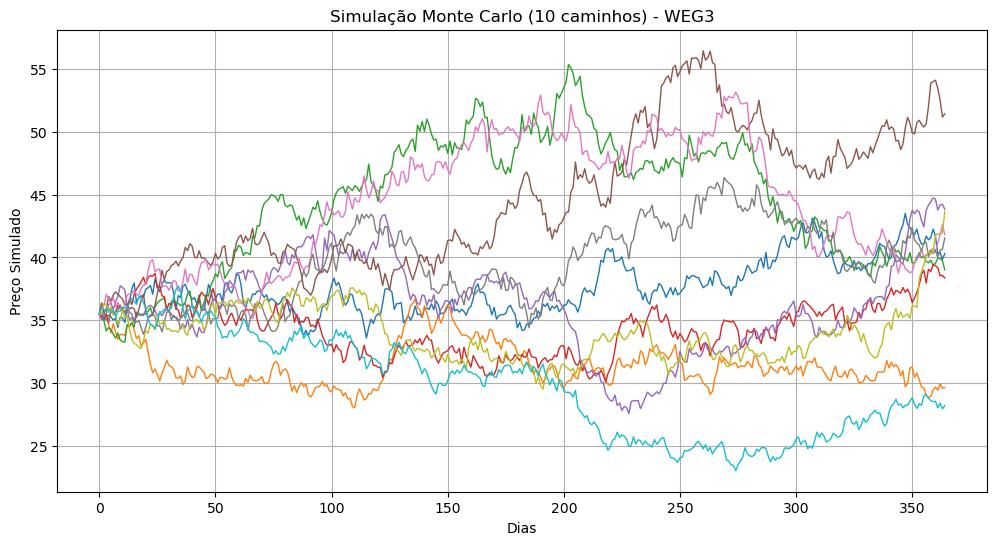

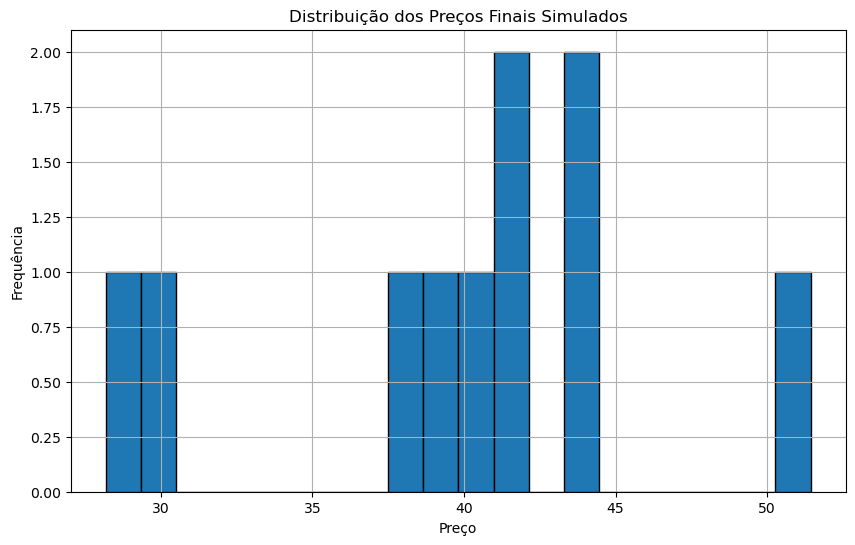

Pre√ßo m√©dio final: 39.78
Desvio padr√£o: 6.44
VaR (95%): R$ 0.00
Percentil 5%: R$ 35.50


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

def simulacao(ticker, nome):
    data = ticker.copy()

    # C√°lculo dos retornos logar√≠tmicos
    log_retorno = np.log(1 + data["PrecoFechamento"].pct_change().dropna())
    u = log_retorno.mean()
    var = log_retorno.var()
    stdev = log_retorno.std()
    drift = u - (0.5 * var)

    # Par√¢metros da simula√ß√£o
    t_intervalo = 365  # dias
    n_simulacoes = 10  # n√∫mero de simula√ß√µes

    # Matriz de retornos simulados
    rand = np.random.rand(t_intervalo, n_simulacoes)
    retorno_simulado = np.exp(drift + stdev * norm.ppf(rand))

    # Inicializa√ß√£o da matriz de pre√ßos simulados
    s0 = data["PrecoFechamento"].iloc[-1]  # √∫ltimo pre√ßo conhecido
    preco_simulado = np.zeros_like(retorno_simulado)
    preco_simulado[0] = s0  # todos os caminhos come√ßam no mesmo pre√ßo

    # Simula√ß√£o dos pre√ßos
    for t in range(1, t_intervalo):
        preco_simulado[t] = preco_simulado[t - 1] * retorno_simulado[t]

    # Plot
    plt.figure(figsize=(12, 6))
    for i in range(n_simulacoes):
        plt.plot(preco_simulado[:, i], lw=1)
    plt.title("Simula√ß√£o Monte Carlo ({} caminhos) - {}".format(n_simulacoes, nome))
    plt.xlabel("Dias")
    plt.ylabel("Pre√ßo Simulado")
    plt.grid(True)
    plt.show()
    
    return preco_simulado
    
    
def distribuicao_precos_finais(preco_simulado):
    precos_finais = preco_simulado[-1]  # √∫ltimo dia de cada simula√ß√£o

    plt.figure(figsize=(10, 6))
    plt.hist(precos_finais, bins=20, edgecolor='black')
    plt.title("Distribui√ß√£o dos Pre√ßos Finais Simulados")
    plt.xlabel("Pre√ßo")
    plt.ylabel("Frequ√™ncia")
    plt.grid(True)
    plt.show()

    media = np.mean(precos_finais)
    desvio = np.std(precos_finais)
    print(f"Pre√ßo m√©dio final: {media:.2f}")
    print(f"Desvio padr√£o: {desvio:.2f}")

    return precos_finais

def estimar_var(precos_finais, preco_atual, nivel_confianca=0.95):
    percentil = np.percentile(precos_finais, (1 - nivel_confianca) * 100)
    var = preco_atual - percentil

    print(f"VaR ({int(nivel_confianca * 100)}%): R$ {var:.2f}")
    print(f"Percentil {int((1 - nivel_confianca) * 100)}%: R$ {percentil:.2f}")

    return var
    
preco_simulado = simulacao(df,"WEG3")
distribuicao_precos_finais(preco_simulado)
precos_finais = preco_atual = df["PrecoFechamento"].iloc[-1]
var_95 = estimar_var(precos_finais, preco_atual, nivel_confianca=0.95)


Estimar VaR (Value at Risk)
üéØ Objetivo:
Estimar o risco de perda m√°xima com 95% de confian√ßa (VaR), usando os pre√ßos finais simulados.

VaR_Œ± = valor atual - percentil Œ± dos pre√ßos simulados finais
